# Домашнее задание, вариант 26
# Держаев Антон

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests

sns.set(style='white')

%matplotlib inline

In [11]:
data = pd.read_excel('dz1stats.xlsx')
data=data.iloc[:,[0,1,2,3,4]]
data

,ID,Возраст,"Курение(1-да, 0-нет)",Атеросклероз аорты,Эритроциты
0,1,67.0,0.0,0.0,4.500
1,2,45.0,0.0,0.0,4.880
2,3,63.0,0.0,0.0,4.500
3,4,43.5,0.0,0.0,4.850
4,5,68.0,1.0,0.0,4.670
...,...,...,...,...,...
107,108,58.0,1.0,0.0,4.510
108,109,55.0,0.0,0.0,5.130
109,110,56.0,0.0,1.0,NaN
110,111,45.0,1.0,0.0,5.109


Проверим качественные признаки на нормальность

In [12]:
data1=data.iloc[:,[1,4]]
data1.dropna(inplace=True)
data1=data1.to_numpy()
data1=data1.T
data1=data1[0:]
columns = ['Возраст', "Эритроциты"]

/var/folders/31/pj5t3xpj63j607j_6f0y4kb80000gn/T/ipykernel_4707/446810137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.dropna(inplace=True)


Посмотрим Q-Q plot для признаков

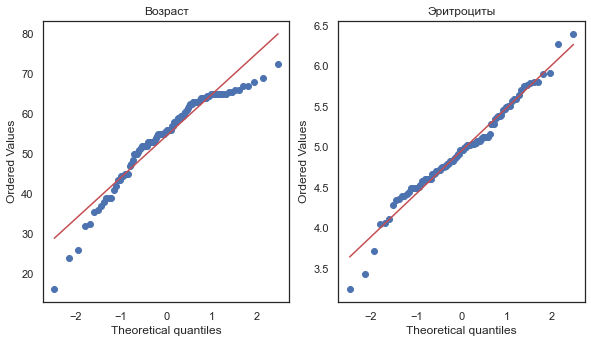

In [13]:
columns=["Возраст", "Эритроциты"]
plt.figure(figsize=(15,30))
for i in range(len(data1)):
    a=plt.subplot(5, 3, i+1)
    sps.probplot(data1[i], plot=a)
    plt.title(columns[i])

Визуально распределние по эритроцитам близко к нормальному, а вот с возрастом не уверен

In [14]:
pvalues=[]
for i in range(len(data1)):
    pvalues.append([])
    pvalues[i].append(sps.kstest(data1[i], sps.norm(*sps.norm.fit(data1[i])).cdf)[1])
    pvalues[i].append(sps.jarque_bera(data1[i])[1])
    pvalues[i].append(sps.shapiro(data1[i])[1])
    
pvalues=np.array(pvalues)
pvalues_corrected = multipletests(pvalues.ravel(), method='holm')[1].reshape(2,3)

reject=np.array([])
for i in range(len(data1)):
    H0=True
    for elem in pvalues_corrected[i]:
        if elem<0.05:
            H0=False
    if H0: 
        reject = np.append(reject, 'False')
    else:
        reject = np.append(reject, 'True')

reject=np.array(reject)
columns=np.array(columns)
criterias=np.array(['Колмогоров', 'Жарк-Бера', 'Шапиро-Уилк', 'Отвержение'])

pvalues_corrected=np.concatenate((pvalues_corrected, reject.reshape(-1,1)), axis=1)

pvalues_corrected=pd.DataFrame(pvalues_corrected, columns, criterias)

pvalues_corrected

,Колмогоров,Жарк-Бера,Шапиро-Уилк,Отвержение
Возраст,0.2961375217131721,1.3132717921138237e-05,7.14366979082115e-05,True
Эритроциты,0.2961375217131721,0.2961375217131721,0.2961375217131721,False


Проведя МПГ становится понятно, что для признака "Возраст" можно отвергнуть нулевую гипотезу о нормальности распределения данных. 

Рассмотрим признаки Курение-Эритроциты

In [15]:
SmokEr=data.copy()

Оценим данные визуально

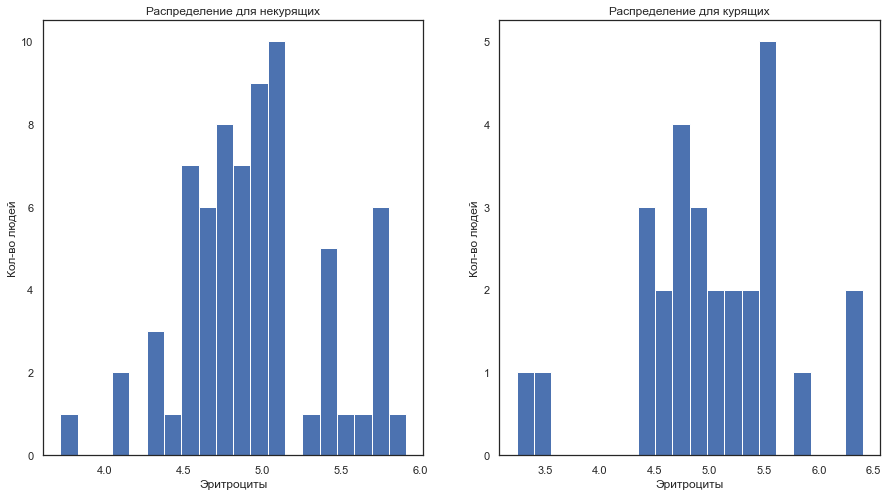

In [16]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.hist(SmokEr[SmokEr['Курение(1-да, 0-нет)']==0]['Эритроциты'], bins=20)
plt.title('Распределение для некурящих')
plt.xlabel('Эритроциты') 
plt.ylabel('Кол-во людей')
plt.subplot(122)
plt.hist(SmokEr[SmokEr['Курение(1-да, 0-нет)']==1]['Эритроциты'], bins=20)
plt.title('Распределение для курящих')
plt.xlabel('Эритроциты')
plt.ylabel('Кол-во людей')
plt.show()

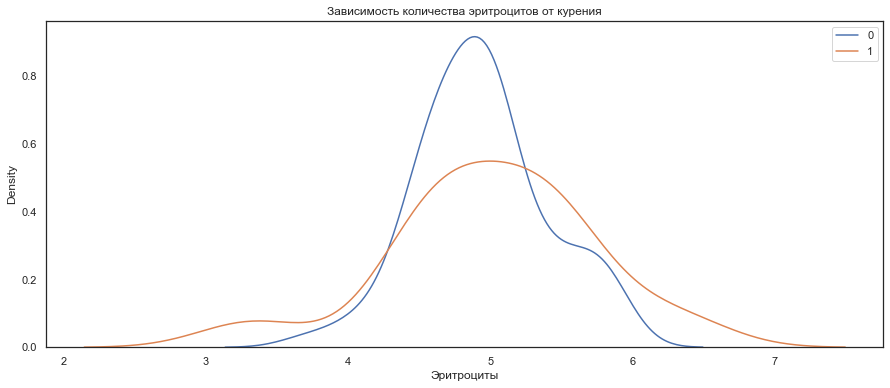

In [17]:
plt.figure(figsize=(15,6))
sns.kdeplot(data[data['Курение(1-да, 0-нет)'] == 0].iloc[:, 4], label='0').set_title('Зависимость количества эритроцитов от курения')
sns.kdeplot(data[data['Курение(1-да, 0-нет)'] == 1].iloc[:, 4], label='1')
plt.legend()
plt.show()

Чисто визуально из гистограмм, можно прикинуть, что у курящих у большего процента людей число эритроцитов выше нормы(4-5). (+можно отметить, что курящик людей раза в 2 меньше).Значимое ли это различие, мы сейчас проверим. Из ядерной оценки плотности видно, что отличие незначительное.

In [18]:
SmokEr.dropna(inplace=True)

In [19]:
corr, pv1 = sps.pearsonr(SmokEr['Курение(1-да, 0-нет)'], SmokEr['Эритроциты'])
print(f'Коэффициент корреляции Пирсона равен {round(corr, 4)} с p-value = {round(pv1, 4)}')

Коэффициент корреляции Пирсона равен 0.0336 с p-value = 0.7477


p-value > 0.05 - статистически незначимый результат => принимается нулевая гипотеза о том, что нет различий между выборками. Более того доверительный интервал для коэф. корреляции содержит 0. Количество эритроцитов и курение не связаны. 

In [20]:
zr = np.arctanh(corr) 
confidence_level = 0.95
se = np.sqrt(1 / (SmokEr.shape[0] - 3))       
h = scipy.special.ndtri(0.5 + confidence_level/2)
zlo = zr - h*se
zhi = zr + h*se
rlo = np.tanh(zlo)
rhi = np.tanh(zhi)
print(f'Доверительный интервал: {(rlo, rhi)}')

Доверительный интервал: (-0.17015606462314053, 0.23463861044244064)


In [21]:
k1, pv1 = sps.pearsonr(SmokEr['Курение(1-да, 0-нет)'], SmokEr['Эритроциты'])
k2, pv2 = sps.spearmanr(SmokEr['Курение(1-да, 0-нет)'], SmokEr['Эритроциты'])
k3, pv3 = sps.kendalltau(SmokEr['Курение(1-да, 0-нет)'], SmokEr['Эритроциты'])
print(f'Коэффициент корреляции Пирсона равен {round(k1, 4)} с p-value = {round(pv1, 4)}')
print(f'Коэффициент корреляции Cпирмена равен {round(k2, 4)} с p-value = {round(pv2, 4)}')
print(f'Коэффициент корреляции Кендалла равен {round(k3, 4)} с p-value = {round(pv3, 4)}')
print('После МПГ:', multipletests([pv1, pv2, pv3], method='holm')[0])

Коэффициент корреляции Пирсона равен 0.0336 с p-value = 0.7477
Коэффициент корреляции Cпирмена равен 0.0451 с p-value = 0.6663
Коэффициент корреляции Кендалла равен 0.0371 с p-value = 0.6639
После МПГ: [False False False]


Корреляции не наблюдается ни по одному из методов оценки

Проведем аналогичные вычисления для признаков Возраст - Атеросклероз (Хотя возраст вообще не распределен нормально)

In [22]:
AgeAt=data.copy()

In [23]:
AgeAt

,ID,Возраст,"Курение(1-да, 0-нет)",Атеросклероз аорты,Эритроциты
0,1,67.0,0.0,0.0,4.500
1,2,45.0,0.0,0.0,4.880
2,3,63.0,0.0,0.0,4.500
3,4,43.5,0.0,0.0,4.850
4,5,68.0,1.0,0.0,4.670
...,...,...,...,...,...
107,108,58.0,1.0,0.0,4.510
108,109,55.0,0.0,0.0,5.130
109,110,56.0,0.0,1.0,NaN
110,111,45.0,1.0,0.0,5.109


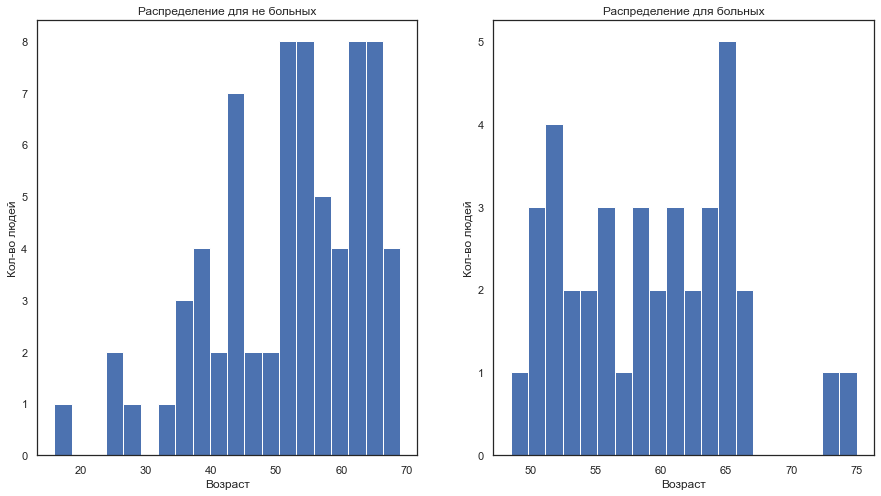

In [25]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.hist(AgeAt[AgeAt['Атеросклероз аорты']==0]['Возраст'], bins=20)
plt.title('Распределение для не больных')
plt.xlabel('Возраст') 
plt.ylabel('Кол-во людей')
plt.subplot(122)
plt.hist(AgeAt[AgeAt['Атеросклероз аорты']==1]['Возраст'], bins=20)
plt.title('Распределение для больных')
plt.xlabel('Возраст')
plt.ylabel('Кол-во людей')
plt.show()

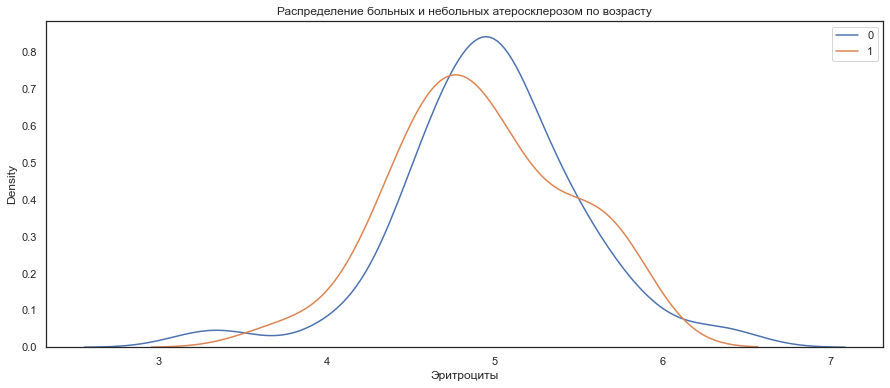

In [26]:
plt.figure(figsize=(15,6))
sns.kdeplot(data[data['Атеросклероз аорты'] == 0].iloc[:, 4], label='0').set_title('Распределение больных и небольных атеросклерозом по возрасту')
sns.kdeplot(data[data['Атеросклероз аорты'] == 1].iloc[:, 4], label='1')
plt.legend()
plt.show()

Как будто больных молодых больше. Но посмотрим, значимая ли это разница

In [27]:
AgeAt.dropna(inplace=True)

In [29]:
corr, pv1 = sps.pearsonr(AgeAt['Атеросклероз аорты'], AgeAt['Возраст'])
print(f'Коэффициент корреляции Пирсона равен {round(corr, 4)} с p-value = {round(pv1, 4)}')

Коэффициент корреляции Пирсона равен 0.2831 с p-value = 0.0057


pvalue < 0,05 => результат статистически значим. Коэффициент корреляции в пределах 0.25 - 0.5 - средняя зависимость признаков. 

In [33]:
k1, pv1 = sps.pearsonr(AgeAt['Атеросклероз аорты'], AgeAt['Возраст'])
k2, pv2 = sps.spearmanr(AgeAt['Атеросклероз аорты'], AgeAt['Возраст'])
k3, pv3 = sps.kendalltau(AgeAt['Атеросклероз аорты'], AgeAt['Возраст'])
print(f'Коэффициент корреляции Пирсона равен {round(k1, 4)} с p-value = {round(pv1, 4)}')
print(f'Коэффициент корреляции Cпирмена равен {round(k2, 4)} с p-value = {round(pv2, 4)}')
print(f'Коэффициент корреляции Кендалла равен {round(k3, 4)} с p-value = {round(pv3, 4)}')
print('После МПГ:', multipletests([pv1, pv2, pv3], method='holm')[0])

Коэффициент корреляции Пирсона равен 0.2831 с p-value = 0.0057
Коэффициент корреляции Cпирмена равен 0.2447 с p-value = 0.0175
Коэффициент корреляции Кендалла равен 0.2031 с p-value = 0.0183
После МПГ: [ True  True  True]


    С большой уверенностью можно отвергнуть гипотезу о том, что атеросклероз и возраст незавсимы(только стоит заметить, что исходные данные по возрасту не распределены нормально=> мы уже на самом начале должны были перестать это проверять:))

In [34]:
!pip install nbconvert[webpdf]

     |████████████████████████████████| 83 kB 882 kB/s eta 0:00:01
     |████████████████████████████████| 97 kB 2.6 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
